In [93]:
import os

import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

!pip install geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

import xgboost as xgb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
BASE_DIR = os.getcwd()
print(f"BASE_DIR is: {BASE_DIR}")
DATASET_DIR = f"/share/Summer-School-2024/Team5/datasets"
REPROJECT_PATH = f"{BASE_DIR}/reprojected-datasets"
OUTPUT_PATH = f"{BASE_DIR}/outputs"

BASE_DIR is: /home/jovyan/yx-iguide


In [4]:
nri_columns = [
        'TRACTFIPS',
        'POPULATION',
        'BUILDVALUE',
        'AGRIVALUE',
        'WFIR_AFREQ',
        'WFIR_EXPB',
        'WFIR_EXPP',
        'WFIR_EXPPE',
        'WFIR_EXPA',
        'WFIR_EXPT',
        'WFIR_HLRB',
        'WFIR_HLRP',
        'WFIR_HLRA',
        'WFIR_HLRR',
        'WFIR_EALB',
    ]

feature_dict_list = [
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_Precipitation_JJA.tif",
        "feature_name": "Precipitation",
        "reprojected_file_name": f"{REPROJECT_PATH}/Precipitation.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmax_JJA.tif",
        "feature_name": "Max-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MaxTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmin_JJA.tif",
        "feature_name": "Min-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MinTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_tmean_JJA.tif",
        "feature_name": "Mean-Temperature",
        "reprojected_file_name": f"{REPROJECT_PATH}/MeanTemperature.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/ClimateEngineTifs/DAYMET_HargreavesPotentialEvapotranspiration_JJA.tif",
        "feature_name": "Potential-Evapotranspiration",
        "reprojected_file_name": f"{REPROJECT_PATH}/PotentialEvapotranspiration.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingCount_TX.tif",
        "feature_name": "Building-Count",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingCount.tif",
        "method": "sum"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingCover_TX.tif",
        "feature_name": "Building-Cover",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingCover.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/BuildingDensity_TX.tif",
        "feature_name": "Building-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/BuildingDensity.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUCount_TX.tif",
        "feature_name": "Housing-Unit-Count",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUCount.tif",
        "method": "sum"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUDen_TX.tif",
        "feature_name": "Housing-Unit-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUDen.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX2/HUExposure_TX.tif",
        "feature_name": "Housing-Unit-Exposure",
        "reprojected_file_name": f"{REPROJECT_PATH}/HUExposure.tif",
        "method": "sum"
    },
    
    {
        "file_name": f"{DATASET_DIR}/TX2/PopDen_TX.tif",
        "feature_name": "Population-Density",
        "reprojected_file_name": f"{REPROJECT_PATH}/PopDen.tif",
        "method": "mean"
    },

    {
        "file_name": f"{DATASET_DIR}/TX/CFL_TX.tif",
        "feature_name": "Conditional-Flame-Length",
        "reprojected_file_name": f"{REPROJECT_PATH}/CFL.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/CRPS_TX.tif",
        "feature_name": "Conditional-Risk-2-Potential-Structures",
        "reprojected_file_name": f"{REPROJECT_PATH}/CRPS.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/FLEP4_TX.tif",
        "feature_name": "Flame-Length-Over-4-Feet",
        "reprojected_file_name": f"{REPROJECT_PATH}/FLEP4.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/FLEP8_TX.tif",
        "feature_name": "Flame-Length-Over-8-Feet",
        "reprojected_file_name": f"{REPROJECT_PATH}/FLEP8.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/RPS_TX.tif",
        "feature_name": "Risk-2-Potential-Structures",
        "reprojected_file_name": f"{REPROJECT_PATH}/RPS.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/BP_TX.tif",
        "feature_name": "Burn-Probability",
        "reprojected_file_name": f"{REPROJECT_PATH}/BP.tif",
        "method": "mean"
    },
    {
        "file_name": f"{DATASET_DIR}/TX/Exposure_TX.tif",
        "feature_name": "Exposure-type",
        "reprojected_file_name": f"{REPROJECT_PATH}/Exposure.tif",
        "method": "mean"
    },
]

In [5]:
def reproject_tif(target_crs, source_tif_path, output_tif_path):
    with rasterio.open(source_tif_path) as src:
        transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        with rasterio.open(output_tif_path, 'w', **kwargs) as dst:
            print(f"Reprojecting {source_tif_path} to {output_tif_path}...")
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)

In [12]:
# reprojection
# this doesn't need to run because reprojected datasets have been uploaded to shared folder: {DATASET_DIR}
census_tracts = gpd.read_file(f"{DATASET_DIR}/tl_2023_48_tract/tl_2023_48_tract.shp")

target_crs = census_tracts.crs

for feature_dict in feature_dict_list:
    reproject_tif(target_crs, feature_dict["file_name"], feature_dict["reprojected_file_name"])


Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_Precipitation_JJA.tif to /home/jovyan/yx-iguide/reprojected-datasets/Precipitation.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmax_JJA.tif to /home/jovyan/yx-iguide/reprojected-datasets/MaxTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmin_JJA.tif to /home/jovyan/yx-iguide/reprojected-datasets/MinTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_tmean_JJA.tif to /home/jovyan/yx-iguide/reprojected-datasets/MeanTemperature.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/ClimateEngineTifs/DAYMET_HargreavesPotentialEvapotranspiration_JJA.tif to /home/jovyan/yx-iguide/reprojected-datasets/PotentialEvapotranspiration.tif...
Reprojecting /share/Summer-School-2024/Team5/datasets/TX2/BuildingCount_TX.tif to /home/jovyan/yx-iguide/reprojected-datasets/BuildingCount

In [6]:
# Aggregation
def add_column_by_feature(gdf, feature_dict):
    raster = rasterio.open(feature_dict["reprojected_file_name"])
    print(f"Fetching values for {feature_dict['feature_name']}...")
    value_list = []
    for _, row in gdf.iterrows():
        geom = [row['geometry'].__geo_interface__]
        out_image, out_transform = mask(raster, geom, crop=True)
        masked = np.ma.masked_array(out_image, out_image == raster.nodata)
        if feature_dict["method"] == "sum":
            sum_value = masked.sum()
            # row[feature_name] = sum_value
            value_list.append(sum_value)
        elif feature_dict["method"] == "mean":
            mean_value = masked.mean()
            # row[feature_name] = mean_value
            value_list.append(mean_value)

    raster.close()
    print(f"Adding {feature_dict['feature_name']} to the GeoDataFrame...")
    gdf.insert(2, feature_dict["feature_name"], value_list)

In [7]:
census_tracts_gdf = gpd.read_file(f"{DATASET_DIR}/tl_2023_48_tract/tl_2023_48_tract.shp")
census_tracts_columns = ['GEOID', 'geometry']
census_tracts_gdf = census_tracts_gdf[census_tracts_columns]

# Initialize a list to store the results
results = []

for _, tract in census_tracts_gdf.iterrows():
    # Extract the geometry in GeoJSON format
    geom = [tract['geometry'].__geo_interface__]

    results.append({
        'GeoId': tract['GEOID'],  # Assuming 'GEOID' is the identifier for the census tract
        'geometry': tract['geometry']  # Add the geometry to the result
    })

gdf = gpd.GeoDataFrame(
    results,
    geometry='geometry',
    crs=census_tracts_gdf.crs  # Use the same CRS as the census tracts
)

gdf['GeoId'] = gdf['GeoId'].astype("int64")

gdf.head()

,GeoId,geometry
0,48157674100,"POLYGON ((-95.61467 29.57828, -95.61339 29.578..."
1,48157674200,"POLYGON ((-95.63989 29.58625, -95.63974 29.586..."
2,48441013501,"POLYGON ((-100.15192 32.08412, -100.15188 32.0..."
3,48441013602,"POLYGON ((-100.14955 32.2816, -100.1495 32.286..."
4,48441013601,"POLYGON ((-100.03974 32.48854, -100.03064 32.4..."


In [8]:
# load NRI data
nri_df = pd.read_csv(f"{DATASET_DIR}/NRI/NRI_Table_CensusTracts_Texas.csv")
nri_df = nri_df[nri_columns]

nri_df.head()

,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_HLRR,WFIR_EALB
0,48001950100,4625,1.032150e+09,14101899.0,0.000717,1.563828e+08,704.509103,8.172306e+09,2.364991e+06,8.331053e+09,0.4,0.000098,0.003613,Relatively Low,41609.963598
1,48001950401,5755,2.146266e+08,946654.0,0.000307,7.118218e+06,33.642175,3.902492e+08,1.852232e+05,3.975527e+08,0.4,0.000098,0.003613,Relatively Low,836.593057
2,48001950402,7115,3.358006e+08,3963665.0,0.000459,7.348517e+06,168.905754,1.959307e+09,8.070112e+05,1.967462e+09,0.4,0.000098,0.003613,Very Low,984.041588
3,48001950500,4479,6.625227e+08,257077.0,0.000114,3.472231e+07,225.768820,2.618918e+09,1.557468e+04,2.653656e+09,0.4,0.000098,0.003613,Very Low,345.038870
4,48001950600,6036,9.216131e+08,274058.0,0.000638,2.320527e+07,244.657193,2.838023e+09,3.922292e+04,2.861268e+09,0.4,0.000098,0.003613,Very Low,2699.934152


In [9]:
# merge NRI data with census tract data
merged_gdf = gdf.merge(
    nri_df, left_on='GeoId', right_on='TRACTFIPS', how='left')

# clean null rows
merged_gdf = merged_gdf.dropna(subset=nri_columns)

merged_gdf.head()

,GeoId,geometry,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_HLRR,WFIR_EALB
0,48157674100,"POLYGON ((-95.61467 29.57828, -95.61339 29.578...",4.815767e+10,6732.0,1.043740e+09,9833.0,0.000010,2.401978e+07,96.338934,1.117532e+09,0.000000e+00,1.141551e+09,0.4,0.000604,0.030198,Relatively Low,96.079121
1,48157674200,"POLYGON ((-95.63989 29.58625, -95.63974 29.586...",4.815767e+10,5179.0,1.537306e+09,3390.0,0.000010,9.481078e+07,268.833563,3.118469e+09,0.000000e+00,3.213280e+09,0.4,0.000604,0.030198,Relatively Moderate,379.243129
2,48441013501,"POLYGON ((-100.15192 32.08412, -100.15188 32.0...",4.844101e+10,2389.0,7.002959e+08,7073207.0,0.003839,3.346794e+08,1114.287022,1.292573e+10,1.838134e+06,1.326225e+10,0.4,0.000066,0.010259,Relatively Moderate,742196.438481
3,48441013602,"POLYGON ((-100.14955 32.2816, -100.1495 32.286...",4.844101e+10,2572.0,6.308193e+08,10778372.0,0.004084,1.944734e+08,866.266151,1.004869e+10,1.423031e+06,1.024458e+10,0.4,0.000066,0.010259,Relatively Low,404450.153379
4,48441013601,"POLYGON ((-100.03974 32.48854, -100.03064 32.4...",4.844101e+10,2996.0,6.610785e+08,433798.0,0.000905,4.563034e+07,291.916874,3.386236e+09,2.380856e+04,3.431890e+09,0.4,0.000066,0.010259,Very Low,15632.203216


In [10]:
merged_gdf.describe()

,GeoId,TRACTFIPS,POPULATION,BUILDVALUE,AGRIVALUE,WFIR_AFREQ,WFIR_EXPB,WFIR_EXPP,WFIR_EXPPE,WFIR_EXPA,WFIR_EXPT,WFIR_HLRB,WFIR_HLRP,WFIR_HLRA,WFIR_EALB
count,6.883000e+03,6.883000e+03,6883.000000,6.883000e+03,6.883000e+03,6883.000000,6.883000e+03,6883.000000,6.883000e+03,6.883000e+03,6.883000e+03,6.883000e+03,6883.000000,6883.000000,6.883000e+03
mean,4.822892e+10,4.822892e+10,4227.762604,7.022567e+08,4.153339e+06,0.000546,6.829160e+07,367.102850,4.258393e+09,8.634936e+05,4.327548e+09,4.000000e-01,0.000301,0.012679,3.325921e+04
std,1.438381e+08,1.438381e+08,2017.405365,8.164234e+08,3.982486e+07,0.001245,1.563668e+08,522.280637,6.058455e+09,1.144108e+07,6.148436e+09,5.107397e-14,0.000361,0.012421,1.341023e+05
min,4.800195e+10,4.800195e+10,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-01,0.000002,0.000002,0.000000e+00
25%,4.811302e+10,4.811302e+10,2859.500000,3.856084e+08,0.000000e+00,0.000010,6.914014e+06,35.997512,4.175711e+08,0.000000e+00,4.300134e+08,4.000000e-01,0.000033,0.000792,4.346028e+01
50%,4.820142e+10,4.820142e+10,3957.000000,5.788933e+08,1.252000e+03,0.000016,2.969097e+07,196.599851,2.280558e+09,0.000000e+00,2.311612e+09,4.000000e-01,0.000103,0.011258,3.014847e+02
75%,4.835500e+10,4.835500e+10,5191.000000,8.457129e+08,2.641325e+05,0.000514,7.803350e+07,476.775649,5.530598e+09,4.058750e+04,5.617622e+09,4.000000e-01,0.000604,0.030198,1.165616e+04
max,4.850795e+10,4.850795e+10,30199.000000,4.717916e+10,1.875880e+09,0.015542,8.815399e+09,7847.459969,9.103054e+10,6.616625e+08,9.188689e+10,4.000000e-01,0.002898,0.068980,2.801460e+06


In [11]:
for feature_dict in feature_dict_list:
    add_column_by_feature(merged_gdf, feature_dict)
    # add_column_by_feature(gdf, feature_dict["reprojected_file_name"], feature_dict["feature_name"])

# change columns from string to float

merged_gdf['Min-Temperature'] = merged_gdf['Min-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")
merged_gdf['Max-Temperature'] = merged_gdf['Max-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")
merged_gdf['Mean-Temperature'] = merged_gdf['Mean-Temperature'].apply(lambda x: np.nan if np.ma.is_masked(x) else x).astype("float64")

merged_gdf = merged_gdf.convert_dtypes()
print(merged_gdf.dtypes)

Fetching values for Precipitation...
Adding Precipitation to the GeoDataFrame...
Fetching values for Max-Temperature...
Adding Max-Temperature to the GeoDataFrame...
Fetching values for Min-Temperature...
Adding Min-Temperature to the GeoDataFrame...
Fetching values for Mean-Temperature...
Adding Mean-Temperature to the GeoDataFrame...
Fetching values for Potential-Evapotranspiration...
Adding Potential-Evapotranspiration to the GeoDataFrame...
Fetching values for Building-Count...
Adding Building-Count to the GeoDataFrame...
Fetching values for Building-Cover...
Adding Building-Cover to the GeoDataFrame...
Fetching values for Building-Density...
Adding Building-Density to the GeoDataFrame...
Fetching values for Housing-Unit-Count...
Adding Housing-Unit-Count to the GeoDataFrame...
Fetching values for Housing-Unit-Density...
Adding Housing-Unit-Density to the GeoDataFrame...
Fetching values for Housing-Unit-Exposure...
Adding Housing-Unit-Exposure to the GeoDataFrame...
Fetching values

In [12]:
merged_gdf.shape

(6883, 36)

In [13]:
merged_gdf.to_file(f"{OUTPUT_PATH}/results.geojson", driver='GeoJSON')

### Combine results data with additional yearbuilt_housingcount.csv

In [5]:
# load geojson data
results_df = gpd.read_file(f"{OUTPUT_PATH}/results.geojson")

# load yearbuilt_housingcount.csv data
add_df = pd.read_csv(f"{OUTPUT_PATH}/yearbuilt_housingcount.csv")

# print dataset shape
print(results_df.shape)
print(add_df.shape)


In [10]:
# change the column name to 'GeoId'
print(add_df.columns)
add_df.rename(columns={'GEOID':'GeoId'}, inplace=True)
print(add_df.columns)

Index(['GEOID', 'yb_min', 'yb_max', 'yb_mean', 'hc_mean', 'hc_sum'], dtype='object')
Index(['GeoId', 'yb_min', 'yb_max', 'yb_mean', 'hc_mean', 'hc_sum'], dtype='object')


In [13]:
# merge the two datasets according to the column of 'GeoId'
merged_df = pd.merge(results_df, add_df, on='GeoId')

In [16]:
# dataset 1: save all the data into a .geojson file
df_all = gpd.GeoDataFrame(merged_df)
df_all.to_file('data_all.geojson', driver='GeoJSON')

In [23]:
# dataset 2: drop the geoid and geometry columns and save into a .csv file
df_drop  = df_all.drop(columns=['GeoId','geometry'])
df_drop.to_csv('data_dropgeo.csv', index=False)

In [25]:
df_std = df_all.drop(columns=['GeoId','geometry','WFIR_HLRR'])

# dataset 3: standardize dataset 1 and save into .geojson file
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_std)
df_norm = pd.DataFrame(scaled_df, index=df_std.index, columns=df_std.columns)
df_norm.to_csv('data_std.csv', index=False)


### Data Cleaning - imputer

In [86]:
# load the original all data
df = pd.read_csv(f"/home/jovyan/Team5/datasets/processed/data_dropgeo.csv")
df = df.drop(columns=["WFIR_HLRR","WFIR_HLRB"])
# fill in nan values
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
# fit and transform the data
df_im = imputer.fit_transform(df)

# standardize dataset
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_im)
# convert the result back to dataframe
df_std = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)


### XGBoost Regression

In [87]:
# load the normalized data
#df_std = pd.read_csv(f"/home/jovyan/Team5/datasets/processed/scaled_results.csv")
df_std

,Exposure-type,Burn-Probability,Risk-2-Potential-Structures,Flame-Length-Over-8-Feet,Flame-Length-Over-4-Feet,Conditional-Risk-2-Potential-Structures,Conditional-Flame-Length,Population-Density,Housing-Unit-Exposure,Housing-Unit-Density,...,WFIR_EXPA,WFIR_EXPT,WFIR_HLRP,WFIR_HLRA,WFIR_EALB,yb_min,yb_max,yb_mean,hc_mean,hc_sum
0,-0.742460,-0.386761,-0.338725,-0.399739,-0.629831,-0.901891,-0.665859,0.236777,-0.396318,0.082419,...,-0.075479,-0.518218,0.838625,1.410574,-0.247315,0.645022,-0.070969,0.159014,0.438157,0.672941
1,-0.390323,-0.367671,-0.330382,-0.399739,-0.713638,-0.137816,-0.648408,-0.280245,-0.359246,-0.339725,...,-0.075479,-0.181241,0.838625,1.410574,-0.245204,0.680601,0.122293,0.266434,-0.300585,-0.098001
2,1.513692,1.401767,1.419342,0.791162,2.420724,1.814296,2.211627,-0.910545,1.358819,-0.779194,...,0.085194,1.453272,-0.651884,-0.194821,5.286925,-0.303745,0.243081,0.050855,-1.016717,0.683489
3,1.008875,1.155661,1.277396,1.165496,2.138267,1.769446,1.844595,-0.909974,1.051351,-0.778583,...,0.048910,0.962434,-0.651884,-0.194821,2.768170,-0.232588,0.243081,0.070506,-1.014954,0.601025
4,0.027967,0.007618,0.047494,0.276955,0.988729,0.402233,0.599744,-0.861292,-0.101664,-0.727851,...,-0.073397,-0.145683,-0.651884,-0.194821,-0.131454,-0.268167,0.218923,-0.125213,-0.894309,0.248156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6878,0.411151,1.272982,1.717703,4.602607,2.339356,1.397739,1.798252,-0.893748,0.059306,-0.769976,...,-0.071220,0.313925,-0.773337,-0.957049,-0.236620,0.004604,0.218923,0.141007,-0.993160,0.598148
6879,-0.659174,-0.286290,-0.261202,0.058186,-0.334679,-0.744096,-0.460398,0.425931,-0.333992,0.211715,...,-0.075013,-0.540884,-0.773337,-0.957049,-0.247821,0.265515,-0.240073,-0.075664,0.854247,-0.794150
6880,-0.281325,-0.242199,-0.244908,-0.377433,-0.281223,0.311014,-0.284891,-0.800987,-0.178450,-0.700537,...,-0.057647,0.967069,-0.773337,-0.957049,-0.245487,0.206217,0.218923,0.117034,-0.847763,-0.004030
6881,-0.495185,-0.281145,-0.261487,-0.368754,-0.272244,-0.313054,-0.396676,-0.883367,-0.306881,-0.761236,...,-0.031964,0.588806,-0.773337,-0.957049,-0.246292,-0.030975,0.146450,0.011042,-0.987579,-0.769219


In [88]:
# define a function to separate the features and target variables
def create_train_test_sets(scaled_df):

    # Split the data into training and testing sets
    label_column = "WFIR_EALB"
    X = scaled_df.drop(columns=[label_column])
    y = scaled_df[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test_sets(df_std)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5506, 36) (1377, 36) (5506,) (1377,)


In [89]:
# create XGBoost regression model
# add early stopping setup
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.05,\
                                 early_stopping_rounds=10, eval_metric="rmse", reg_lambda=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
#eval_set = [(X_test, y_test)]

# train the XGBoost model and record the loss every 5 epochs
xgboost_model.fit(X_train, y_train, eval_set=eval_set, verbose=5)

# XGBoost prediction
y_pred_xgb = xgboost_model.predict(X_test)

[0]	validation_0-rmse:0.93090	validation_1-rmse:1.07275
[5]	validation_0-rmse:0.74966	validation_1-rmse:0.94482
[10]	validation_0-rmse:0.60652	validation_1-rmse:0.84976
[15]	validation_0-rmse:0.49292	validation_1-rmse:0.77978
[20]	validation_0-rmse:0.40212	validation_1-rmse:0.73136
[25]	validation_0-rmse:0.33053	validation_1-rmse:0.69820
[30]	validation_0-rmse:0.27373	validation_1-rmse:0.66867
[35]	validation_0-rmse:0.22805	validation_1-rmse:0.64523
[40]	validation_0-rmse:0.19142	validation_1-rmse:0.62572
[45]	validation_0-rmse:0.16096	validation_1-rmse:0.61154
[50]	validation_0-rmse:0.13553	validation_1-rmse:0.60416
[55]	validation_0-rmse:0.11471	validation_1-rmse:0.59937
[60]	validation_0-rmse:0.09750	validation_1-rmse:0.59595
[65]	validation_0-rmse:0.08365	validation_1-rmse:0.59474
[70]	validation_0-rmse:0.07262	validation_1-rmse:0.59280
[75]	validation_0-rmse:0.06347	validation_1-rmse:0.59026
[80]	validation_0-rmse:0.05621	validation_1-rmse:0.58383
[85]	validation_0-rmse:0.05024	va

In [90]:
# calculate XGBoost mean squared error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Test MSE: {mse_xgb:.4f}')
print(f'XGBoost Test R-squared: {r2_xgb:.4f}')

XGBoost Test MSE: 0.3093
XGBoost Test R-squared: 0.7454


### Hyperparameter tuning for XGBoost regression

In [ ]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5],
    'max_depth': [4, 6, 8, 10],
    
}

In [91]:
# plot predicted values against ground-truth 
plt.figure(figsize=(4,3.8), dpi=200)
plt.scatter(y_test, y_pred_xgb, s=25, c='#1f77b4', marker='o', alpha=0.3)
plt.plot(y_test, y_test, linestyle=':', linewidth=0.8, color='red')
plt.xlim([0, 21])
plt.ylim([0, 21])
plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(0, 21, 5))
plt.xlabel('True values', fontsize=11)
plt.ylabel('Predicted values', fontsize=11)
plt.title('XGBoost regression', fontsize=12)

plt.text(1, 19, f'MSE: {mse_xgb:.4f}', fontsize=10)
plt.text(1, 18, f'R-squared: {r2_xgb:.4f}', fontsize=10)
#plt.show()
plt.savefig('XGBoost.png')
plt.close()

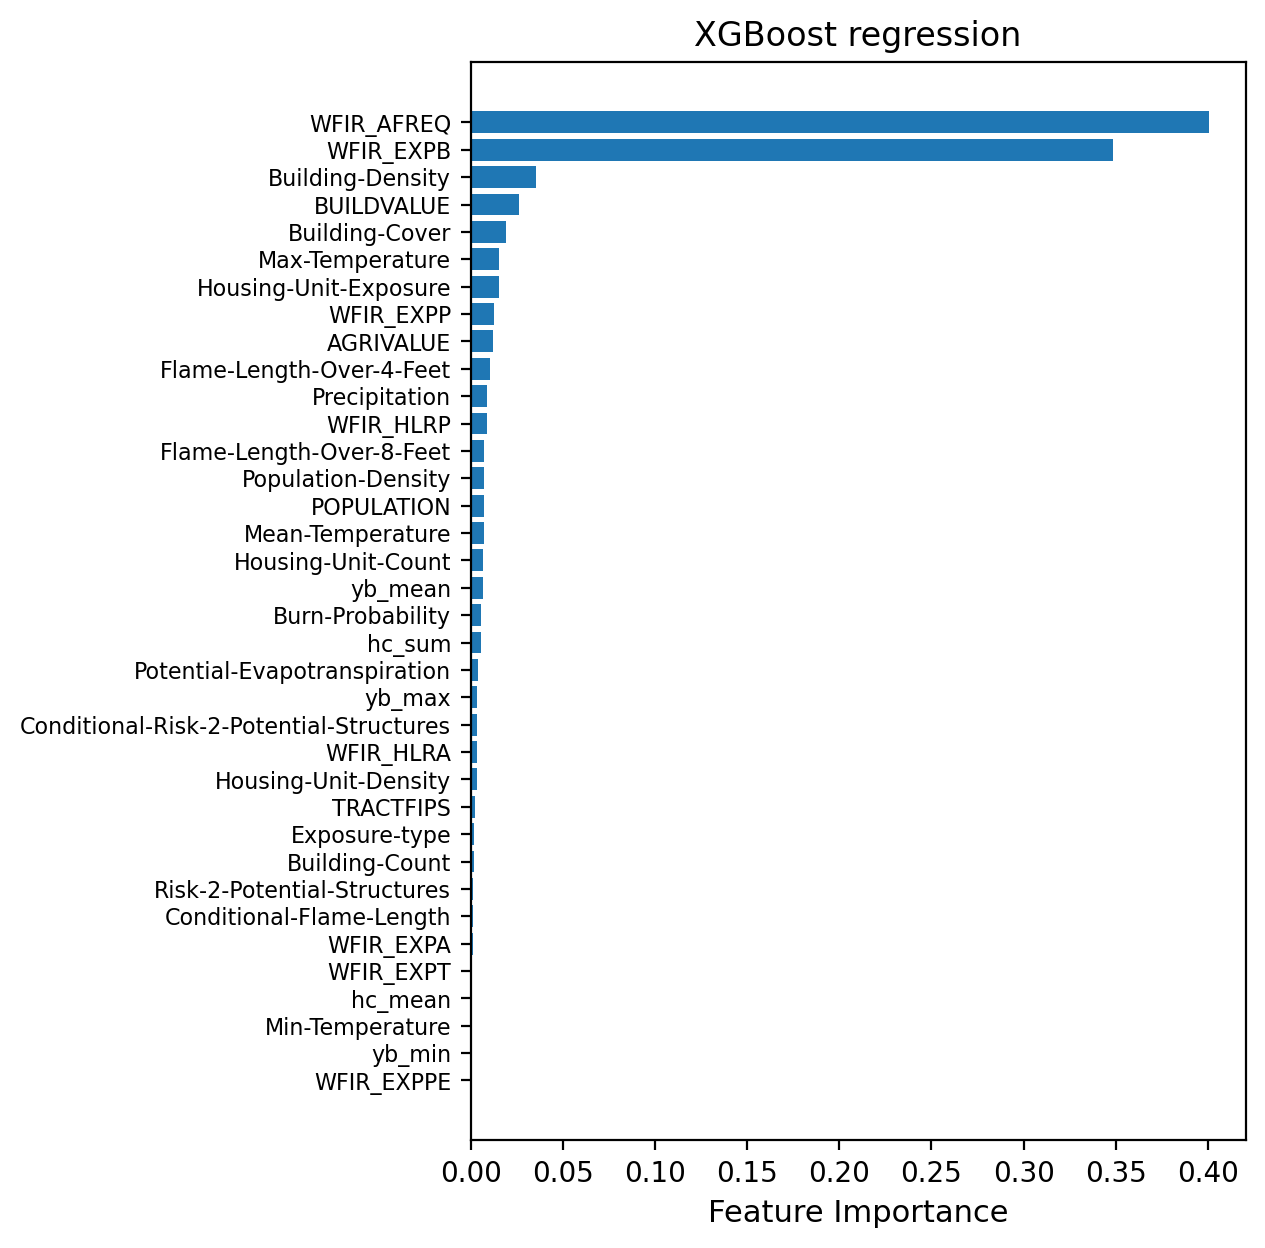

In [92]:
# plot the feature importance figure
feature_importance = xgboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(5,7), dpi=200)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx], fontsize=8)
plt.xlabel('Feature Importance', fontsize=11)
plt.title('XGBoost regression', fontsize=12)
#plt.savefig('XGBoost_FI.png')
plt.show()
plt.close()